# Unet Satcen Finetuning

Fine tune the U-Net model trained on the Airbus dataset using the Satcen dataset.

## Split the Dataset

Load and split the *full* Satcen dataset into **60-20-20 stratified** train, validation and test sets. Save the files in the *satcen_dataset/full/splits/x* (where x: {'train', 'validation', 'test'}) folders.

In [2]:
import os
import pathlib
from PIL import Image, ImageDraw as Drawer
import matplotlib.pyplot as plt
import numpy as np
import ijson
import json
from sklearn.model_selection import train_test_split
import shutil
from fastai.vision.all import *
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

# path to satcen dataset
satcen_path = pathlib.Path('../satcen_dataset/full').resolve()

# path to original satcen dataset
satcen_path_original = pathlib.Path('../satcen_dataset/original').resolve()

### Load the Data

Load all Satcen images with their annotations (bounding boxes) and convert the annotations to binary labels for future use.

In [3]:
# load the full Satcen dataset
satcen = os.listdir(satcen_path/'pictures')

# load the labels (bounding boxes)
labels_file = open(satcen_path/'labels.json')
labels_json = json.load(labels_file)

# convert the bounding boxes into binary labels 0/1
y = np.array([])
for img in satcen:

    bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']
    y = np.append(y, 1 if len(bounding_boxes) > 0 else 0)

# print info about entire dataset
print(f'Total number of Satcen images: {len(satcen)}')
print(f'Total number of labels (annotations): {len(labels_json)}')
print(f'Number of positive observations: {np.sum(y==1)} ({100 * np.sum(y==1) / len(y):.2f}%)')
print(f'Number of negative observations: {np.sum(y==0)} ({100 * np.sum(y==0) / len(y):.2f}%)')

Total number of Satcen images: 9420
Total number of labels (annotations): 9420
Number of positive observations: 1525 (16.19%)
Number of negative observations: 7895 (83.81%)


### Split the Data

Perform a stratified split over the data into train, validation and test sets and save the images (**DONE ONCE**) in the corresponding folders.

In [4]:
# # make the splits
# train_images, test_valid_images, y_train, y_test_valid = train_test_split(satcen, y, test_size=0.4, stratify=y, random_state=27)
# valid_images, test_images, y_valid, y_test = train_test_split(test_valid_images, y_test_valid, test_size=0.5, stratify=y_test_valid, random_state=27)

# # print stats about the splits
# print('Train dataset')
# print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
# print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

# print('\nValidation dataset')
# print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
# print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

# print('\nTest dataset')
# print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
# print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

# # copy the training images
# for img in train_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/train/images'/img
#     shutil.copy(src, dst)

# # copy the validation images
# for img in valid_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/validation/images'/img
#     shutil.copy(src, dst)

# # copy the test images
# for img in test_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits/test/images'/img
#     shutil.copy(src, dst)

print('### 60-20-20 Train-Validation-Test Split ###')
print(f'\nSize of train folder: {len(os.listdir(satcen_path/"splits/train/images"))}')
print(f'Size of validation folder: {len(os.listdir(satcen_path/"splits/validation/images"))}')
print(f'Size of test folder: {len(os.listdir(satcen_path/"splits/test/images"))}')

### 60-20-20 Train-Validation-Test Split ###

Size of train folder: 5652
Size of validation folder: 1884
Size of test folder: 1884


### Split the Data (70-30 Train-Test)

Make a stratified 70-30 train-test split for the final model training and evaluation (**DONE ONCE**). Copy the images into the *satcen_dataset/full/splits_70_30/train* and *satcen_dataset/full/splits_70_30/test* folders.

In [5]:
# # make the split
# train_images, test_images, y_train, y_test = train_test_split(satcen, y, test_size=0.3, stratify=y, random_state=0)

# # print stats about the splits
# print('Train dataset')
# print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
# print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

# print('\nTest dataset')
# print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
# print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)\n')

# # empty the folders
# for img in os.listdir(satcen_path/'splits_70_30/train/images'):
#     os.remove(satcen_path/'splits_70_30/train/images'/img)

# for img in os.listdir(satcen_path/'splits_70_30/test/images'):
#     os.remove(satcen_path/'splits_70_30/test/images'/img)

# # copy the training images
# for img in train_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits_70_30/train/images'/img
#     shutil.copy(src, dst)

# # copy the test images
# for img in test_images:
#     src = satcen_path/'pictures'/img
#     dst = satcen_path/'splits_70_30/test/images'/img
#     shutil.copy(src, dst)

print('### 70-30 Train-Test Split ###')
print(f'\nSize of train folder: {len(os.listdir(satcen_path/"splits_70_30/train/images"))}')
print(f'Size of test folder: {len(os.listdir(satcen_path/"splits_70_30/test/images"))}')

### 70-30 Train-Test Split ###

Size of train folder: 6594
Size of test folder: 2826


### Load the Split Data

Load the train, validation and test data from their corresponding folders. 
Compute the binary labels for each set.

Modify the code below accordingly, depending on whether the 70-30 or 60-20-20 split is used.

In [6]:
# load the data
train_images = os.listdir(satcen_path/'splits_70_30/train/images')
# valid_images = os.listdir(satcen_path/'splits/validation/images')
test_images = os.listdir(satcen_path/'splits_70_30/test/images')

# compute binary labels for each set
y_train = np.array([y[satcen.index(img)] for img in train_images])
# y_valid = np.array([y[satcen.index(img)] for img in valid_images])
y_test = np.array([y[satcen.index(img)] for img in test_images])

# print stats about the splits
print('Train dataset')
print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

# print('\nValidation dataset')
# print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
# print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
# print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

print('\nTest dataset')
print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

Train dataset
Size: 6594 (70.00%)
Positive observations: 1068 (16.20%)
Negative observations: 5526 (83.80%)

Test dataset
Size: 2826 (30.00%)
Positive observations: 457 (16.17%)
Negative observations: 2369 (83.83%)


## Generate Ground Truth Labels

Compute ground truth for images in the Satcen dataset based on the given bounding boxes.
Ground truth labels should be saved as *.png* files in the *satcen_dataset/ground_truth_masks* folder. Files should have _L at the end of the filename.

In each ground truth image:
- 0 pixel value represents background pixel
- 1 pixel value represents ship pixel

In [7]:
# compute segmentation mask of a Satcen image based on its bounding box
# @param img_name - filename of the image for which to compute ground truth
# @param bounding_boxes - list of bounding boxes for that image
# @param save - whether or not to save the mask
# @param path - where to save the mask
# @return mask - PIL image representing the mask of the given image
def get_image_mask_satcen(img_name, bounding_boxes, path, save = False):
    
    # create the skeleton of the segmentation mask
    # size is constant for satcen dataset, 256 x 256
    mask = Image.fromarray(np.zeros((256, 256)), 'P')

    # get a drawer object
    draw = Drawer.Draw(mask)

    # loop through the bounding boxes
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw the bounding box on the image
        draw.polygon(coords, fill=1)

    if save:
        mask.save(path/f'{img_name[:-4]}_L.png')

    return mask

# function that generates and saves masks for Satcen images
# @param path - where to save the masks
def save_all_satcen_masks(path):

    # delete all the files in the target directory
    for f in os.listdir(path):
        os.remove(path/f)

    # loop through all satcen images
    for img in satcen:

        # get the corresponding list of bounding boxes
        bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']

        # generate and save mask
        get_image_mask_satcen(img, bounding_boxes, path, save=True)

# save_all_satcen_masks(satcen_path/'ground_truth_masks')

### Show a Few Examples

/tmp/ipykernel_3480/162180313.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/tmp/ipykernel_3480/162180313.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


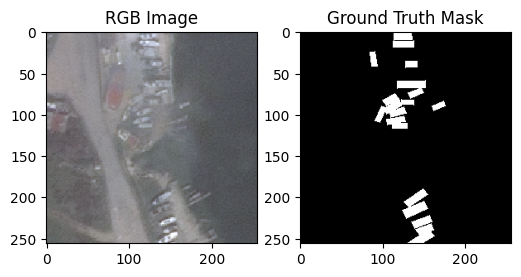

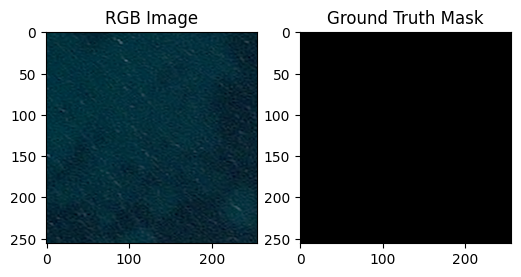

In [8]:
# get one image that contains ships and one that does not
ship_img = satcen[np.where(y==1)[0][0]]
no_ship_img = satcen[np.where(y==0)[0][1]]

# show images and ground truth
fig = plt.subplots(1, 3, figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow(Image.open(satcen_path/'pictures'/ship_img))
plt.subplot(1, 2, 2)
plt.title('Ground Truth Mask')
plt.imshow(PILMask.create(satcen_path/'ground_truth_masks'/f'{ship_img[:-4]}_L.png'), cmap='gray')
plt.show()

fig = plt.subplots(1, 2, figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow(Image.open(satcen_path/'pictures'/no_ship_img))
plt.subplot(1, 2, 2)
plt.title('Ground Truth Mask')
plt.imshow(PILMask.create(satcen_path/'ground_truth_masks'/f'{no_ship_img[:-4]}_L.png'), cmap='gray')
plt.show()

## Fine Tuning

### Construct the Model

Construct the model in the same way as the original one trained on the Airbus dataset. Load the weights of the Airbus model.

/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 4 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 192 x 64 x 64   
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     4 x 192 x 32 x 32   
MaxPool2d                                   

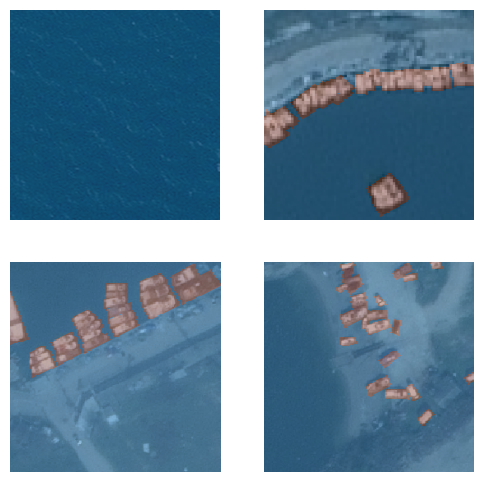

In [9]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'ground_truth_masks'/f'{fn.stem}_L.png'

# create a datablock
dblock = DataBlock( 
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='test')
)

# load the data in the datablock
dataset = dblock.datasets(satcen_path/'splits_70_30/')
dls = dblock.dataloaders(satcen_path/'splits_70_30/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=12)

# create the learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4,
    metrics=[JaccardCoeff()]
)

# load the model
unet.load('unet_airbus_80_20')

# print model architecture
unet.summary()

### Train the Model

Train using the same approach as the original model, then save the model.

In [10]:
# # train the model
# unet.fine_tune(4, freeze_epochs=3)

# # save the model
# print('Saving model...')
# unet.save('unet_finetuned_satcen_70_30')
# print('Saved model')

epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.007210,0.011049,0.479174,23:56
1,0.009931,0.020438,0.012738,24:08
2,0.010770,0.006344,0.430349,24:02


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.004571,0.018309,0.417993,24:13
1,0.003487,0.003732,0.683405,24:06
2,0.002755,0.003463,0.707591,24:10
3,0.003089,0.003359,0.727198,24:09


Saving model...
Saved model


## Testing

Test the fine-tuned model on the **validation set** (*satcen_dataset/full/splits/validation/images*). 

### Define Activation and Decoding Functions

The fast.ai implementation of FocalLoss does not come with built-in activation and decoding functions. The output of U-net consists of two values for each pixel, one corresponding to the ship class and the other to the background class. 

Implement and attach the functions to the FocalLoss loss function as follows:
- **activation:** apply *softmax* pixel-wise on the two values
- **decodes:** take the pixel-wise *argmax* of the two values

In [10]:
# define activation function
def focalLossActivation(self, x:Tensor) -> Tensor:
    return F.softmax(x, dim=1)

# define loss function
def focalLossDecodes(self, x:Tensor) -> Tensor:
    return x.argmax(dim=1)

# attach the functions to focal loss
FocalLoss.activation = focalLossActivation
FocalLoss.decodes = focalLossDecodes

### Load the model

Load the fine-tuned U-net model.

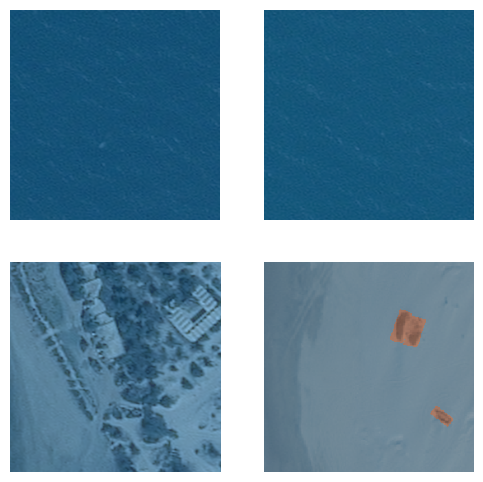

In [11]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'ground_truth_masks'/f'{fn.stem}_L.png'

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='test')
)

# load the data in the datablock
torch.cuda.init()
dataset = dblock.datasets(satcen_path/'splits_70_30/')
dls = dblock.dataloaders(satcen_path/'splits_70_30/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=16)

# create the learner
unet_finetuned = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet_finetuned.load('unet_finetuned_satcen_70_30')

### Generate the Predictions

Perform inference on the validation set.

The *get_preds* function returns a tuple representing **(prediction, target)**. The prediction has shape 1884 x 2 x 256 x 256, as there are 1884 observations in the validation set and the output has not been decoded. The raw outputs have been passed through the *softmax* activation function.

In [10]:
# torch.cuda.empty_cache()
# preds, targets = unet_finetuned.get_preds()

In [12]:
preds = torch.zeros([len(dataset.valid), 2, 256, 256])

with unet_finetuned.no_bar():

    # loop through all images in the test dataset (called "valid" by fast.ai)
    for i, entry in enumerate(dataset.valid):

        # perform inference on the image
        prediction = unet_finetuned.predict(entry[0])

        # store the prediction
        # preds.append(prediction[2])
        preds[i] = prediction[2]

### Decode the Predictions (argmax decoding)

U-net outputs two values for each pixel, one corresponding to the ship class and the other to the background class. To decode the output, choose the greater value.

In [13]:
decoded_preds = preds.argmax(dim=1)
print(decoded_preds.shape)

torch.Size([2826, 256, 256])


Sanity check that everything *decoded_preds* and *valid_images* (and thus *y_valid*) are in the same order. Necessary to ensure that evaluation is conducted properly (prediction and ground truth are compared for the same image).

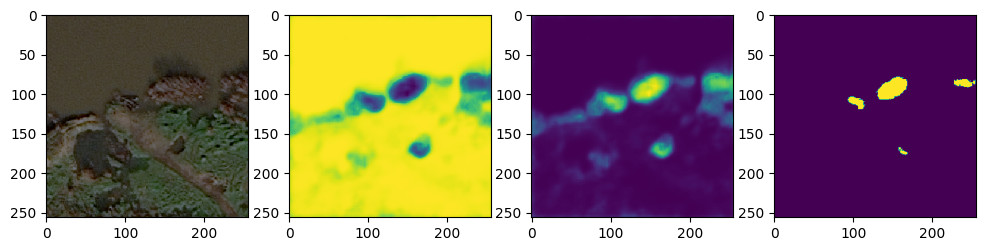

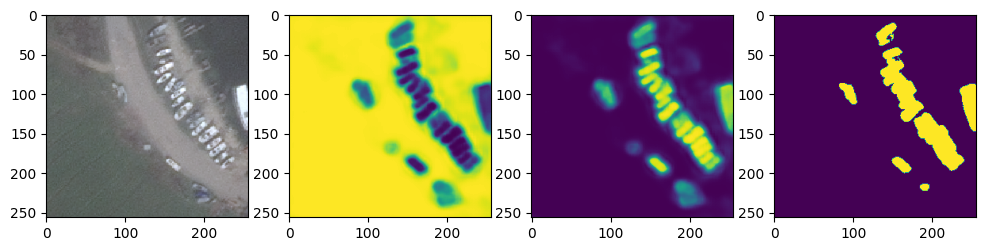

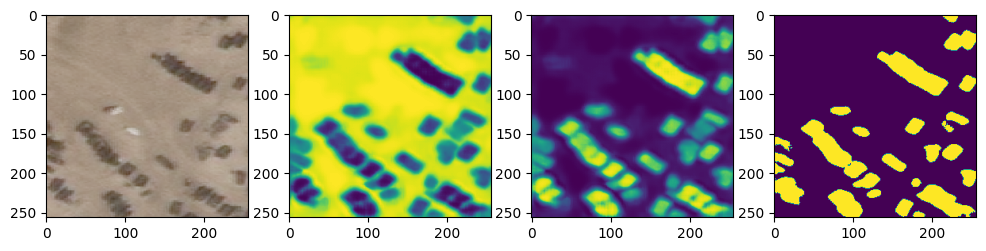

In [14]:
for i in [108, 210, 615]:
    plt.subplots(1,4, figsize=(12,3))
    plt.subplot(1,4,1)
    plt.imshow(Image.open(satcen_path/'pictures'/test_images[i]))
    plt.subplot(1,4,2)
    plt.imshow(preds[i][0])
    plt.subplot(1,4,3)
    plt.imshow(preds[i][1])
    plt.subplot(1,4,4)
    plt.imshow(decoded_preds[i])
    plt.show()

### Save Outputs

Save the decoded outputs of U-net on the validation set as numpy matrices. Store the files in the **satcen_dataset/full/unet_test_outputs** folder.

The format of the filenames should be: *filename_unet_out.npy*

In [17]:
# loop through the outputs and filenames
for filename, output in zip(test_images, decoded_preds):
    
    # construct new filename
    new_filename = f'{filename[:-4]}_unet_out'
    
    # convert output to numpy array
    output = output.numpy()

    # save output
    np.save(satcen_path/'unet_test_outputs'/new_filename, output)

### Compute Metrics

If the decoded output contains at least 1 ship pixel (pixel value = 1), it is classified as a positive observation. Otherwise, it is a negative observation.

With this approach, calculate: *TP*, *FP*, *TN*, *FN*, *precision*, *TPR* *(recall)*, *FPR*.

Also, save the filenames of the images that are identified as positive by U-net. We will use this list further in the pipeline to generate object detections.

Images in the dataloader (and thus in *decoded_preds*) are in the same order as in the *valid_images* array.

In [15]:
# filenames of positive predictions
# will be used later in the pipeline
positive_predictions = []

tp, fp, tn, fn = 0, 0, 0, 0

# loop through the predictions
for i, pred_image in enumerate(decoded_preds):
    
    # determine the label
    y_pred = 1 if torch.count_nonzero(pred_image) > 0 else 0

    # get the actual label
    y_true = y_test[i]

    # determine the type of prediction
    if y_pred == 1:

        # save the filename if it is a positive prediction
        positive_predictions.append(test_images[i])

        if y_true == 1:
            tp += 1
        else:
            fp += 1
    else:
        if y_true == 0:
            tn += 1
        else:
            fn += 1

# calculate condition positives and condition negatives
condition_pos = np.sum(y_test==1)
condition_neg = np.sum(y_test==0)

# calculate precision, recall, FPR
precision = tp / (tp + fp)
recall = tp / condition_pos
fpr = fp / condition_neg

# report metrics
print('Results using argmax approach')
print(f'TP: {tp}')
print(f'FP: {fp}')
print(f'TN: {tn}')
print(f'FN: {fn}')
print()
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'FPR: {fpr}')

# save the list (as a numpy array) of positive predictions
np.save('pipeline/unet_positive_predictions_70_30_test', np.array(positive_predictions))

Results using argmax approach
TP: 438
FP: 23
TN: 2346
FN: 19

Precision: 0.9501084598698482
Recall: 0.9584245076586433
FPR: 0.009708737864077669


### Number of Ship Pixels Predicted

Plot a histogram of the number of ship pixels predicted in each image. Only consider positive predictions.

Minimum number of ship pixels: 1
Maximum number of ship pixels: 35213


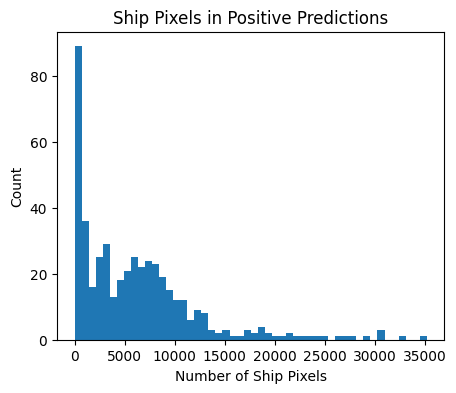

In [23]:
# only consider positive predictions
positive_predictions = [prediction for prediction in decoded_preds if torch.any(prediction==1)]

# get the number of ship pixels in each positive prediction
ship_pixels_predicted = [torch.count_nonzero(prediction) for prediction in positive_predictions]

# display min and max
print(f'Minimum number of ship pixels: {np.min(ship_pixels_predicted)}')
print(f'Maximum number of ship pixels: {np.max(ship_pixels_predicted)}')

# plot histogram
plt.figure(figsize=(5,4))
plt.hist(ship_pixels_predicted, bins=50)
plt.xlabel('Number of Ship Pixels')
plt.ylabel('Count')
plt.title('Ship Pixels in Positive Predictions')
plt.show()

### ROC and PR Curves

For each pixel in the input image, we get 2 probabilities (that sum up to 1), after the raw output of U-net has been passed through the softmax activation function:
- probability that the pixel is *background*
- probability that the pixel is *ship*

Threshold the probability that the pixel is a ship pixel and plot the ROC and PR curves.


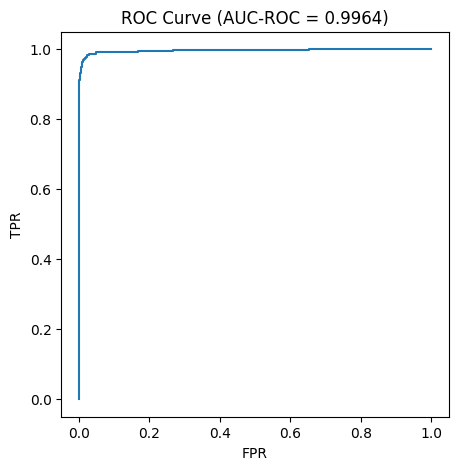

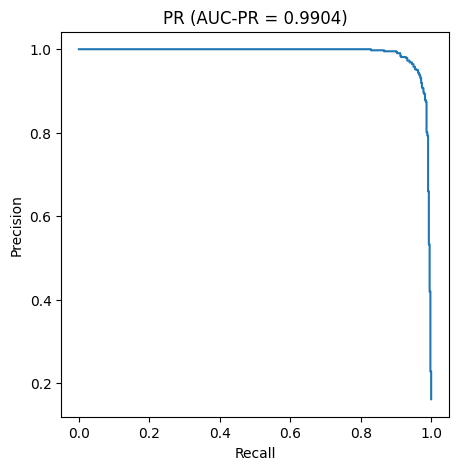

In [16]:
# compute and save decision scores
z = [torch.max(probs) for probs in preds[:, 1]]
np.save(satcen_path/'roc_pr_curve_data/test_set_decision_scores', z)

# also save the ground truth
np.save(satcen_path/'roc_pr_curve_data/test_set_ground_truth.npy', y_test)

# define figure size for all plots
figsize = (5, 5)

# ROC
fprs, tprs, thresholds = roc_curve(y_test, z)
plt.figure(figsize=figsize)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC-ROC = {auc(fprs, tprs):.4f})')
plt.show()

# plt.figure(figsize=figsize)
# plt.plot(thresholds[1:], fprs[1:], thresholds[1:], tprs[1:])
# plt.xlabel('Threshold')
# plt.ylabel('Percentage')
# plt.legend(['FPR', 'TPR'], loc='upper right')
# plt.title('FPR and TPR Against Threshold')
# plt.show()

# PR
precisions, recalls, thresholds = precision_recall_curve(y_test, z)
plt.figure(figsize=figsize)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR (AUC-PR = {auc(recalls, precisions):.4f})')
plt.show()

# thresholds = np.append(thresholds, math.inf)
# plt.figure(figsize=figsize)
# plt.plot(thresholds, precisions, thresholds, recalls)
# plt.xlabel('Threshold')
# plt.ylabel('Percentage')
# plt.title('Precision and Recall Against Threshold')
# plt.legend(['Precision', 'Recall'])
# plt.show()

### Qualitative Analysis

Show some examples of the model's output in order to get a better idea about the quality of the predictions.

Show:
- 10 False Negatives
- 10 False Positives
- 10 True Positives 

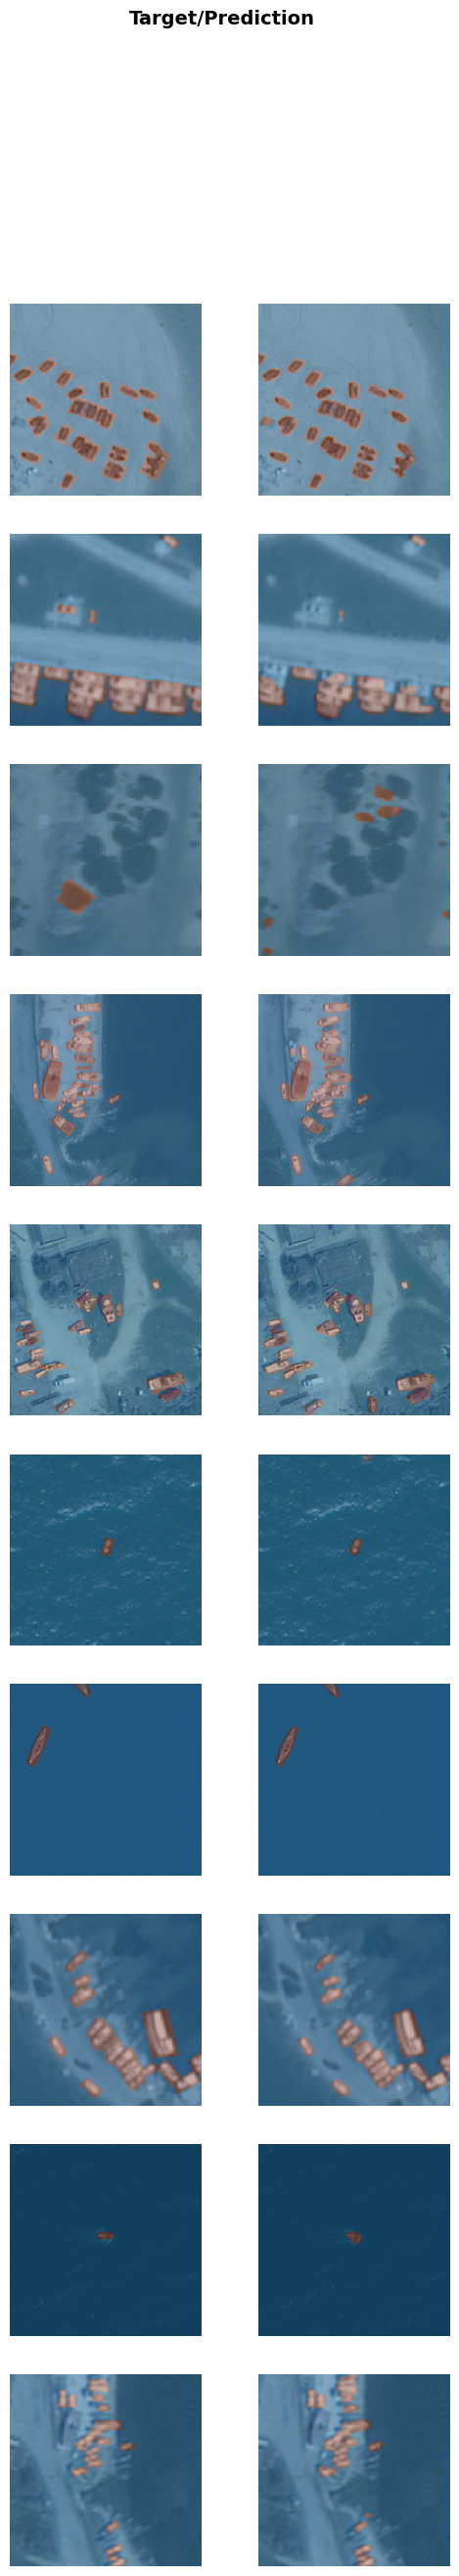

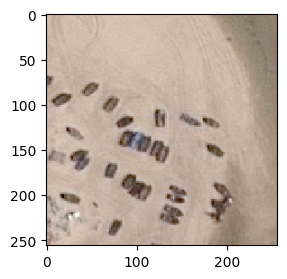

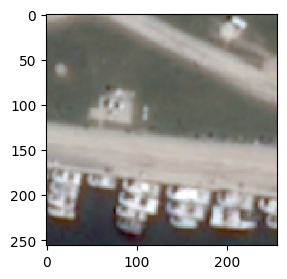

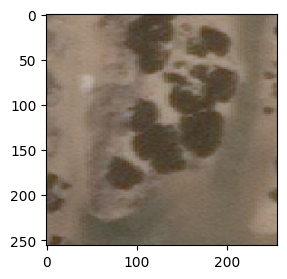

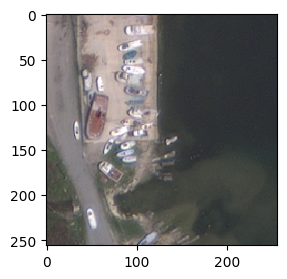

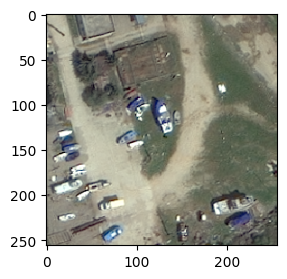

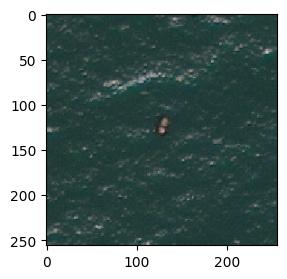

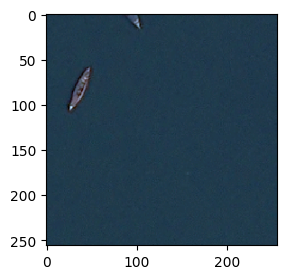

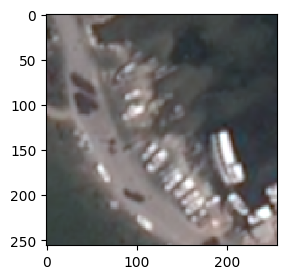

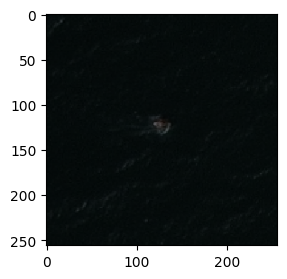

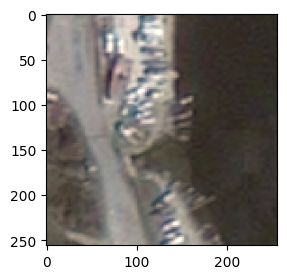

In [17]:
# convert decoded predictions into binary labels
y_pred = np.array([1 if torch.any(decoded==1) else 0 for decoded in decoded_preds])

# find the FN indices
fn_indices = set(np.where(y_test==1)[0]).intersection(set(np.where(y_pred==0)[0]))

# find the FP indices and choose 10 random indices
fp_indices = set(np.where(y_test==0)[0]).intersection(set(np.where(y_pred==1)[0]))
fp_indices = random.sample(fp_indices, k=10)

# find the TP indices and choose 10 random indices
tp_indices = set(np.where(y_test==1)[0]).intersection(set(np.where(y_pred==1)[0]))
tp_indices = random.sample(tp_indices, k=10)

# concatenate indices
idx = [*tp_indices]

# show results for the given indices
interp = SegmentationInterpretation.from_learner(unet_finetuned)
interp.show_results(idx)
plt.show()

# show original images
for i in idx:
    
    # open the image
    img = Image.open(satcen_path/'pictures'/test_images[i])
    
    # show the image
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.show()

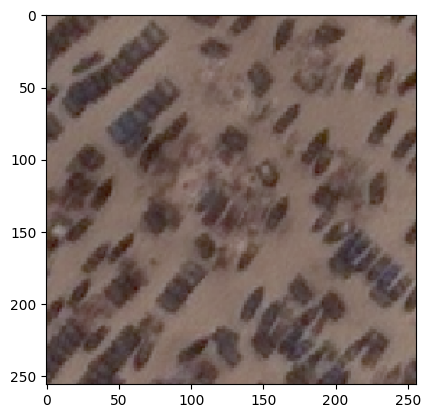

In [16]:
plt.imshow(Image.open(satcen_path/'pictures'/test_images[idx[0]]))

## Number of Ship Pixels

Plot a histogram of the number of ship pixels in the images that contain ships.

Minimum number of ship pixels: 48
Maximum number of ship pixels: 34966


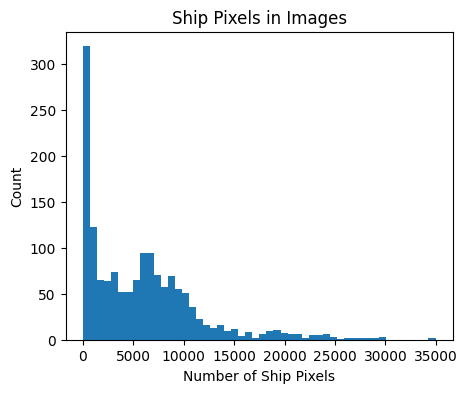

In [16]:
# get the filenames of the images that contain ships
ship_images_fn = [entry['name'] for entry in list(filter(lambda x: len(x['bounding_boxes']) > 0, labels_json))]

# list that stores the number of ship pixels in each image
no_ship_pixels = []

# loop through all ship images
for img in ship_images_fn:

    # load the ground truth mask
    mask = np.array(Image.open(satcen_path/'ground_truth_masks'/f'{img[:-4]}_L.png'))

    # count the number of ship pixels (non zero entries)
    ship_pixels_mask = np.count_nonzero(mask)

    # append to the list
    no_ship_pixels.append(ship_pixels_mask)

# plot min and max
print(f'Minimum number of ship pixels: {np.min(no_ship_pixels)}')
print(f'Maximum number of ship pixels: {np.max(no_ship_pixels)}')

# plot histogram
plt.figure(figsize=(5,4))
plt.hist(no_ship_pixels, bins=50)
plt.xlabel('Number of Ship Pixels')
plt.ylabel('Count')
plt.title('Ship Pixels in Images')
plt.show()